TokaMaker Example: Vertical stability in CUTE for different elongations {#doc_tMaker_CUTE_ex2}
==========
In this example we demonstrate:

 1. How to create a sequence of positive triangularity CUTE equilibrium using a inverse solves
 2. How to compute linear and nonlinear growth rates for each case and plot the results

This example utilizes the mesh built in \ref doc_tMaker_CUTE_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux

## Setup calculation

### Initialize TokaMaker object
We create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker(debug_level=0)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_recon
Revision id:          2a7d23a
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_CUTE_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('CUTE_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.settings.lim_zmax = 0.38 # Prevent limiting in upper/lower divertor areas
mygs.setup(order=2,F0=0.17)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.301E+00
    # of points  =    5780
    # of edges   =   17235
    # of cells   =   11456
    # of boundary points =     102
    # of boundary edges  =     102
    # of boundary cells  =     102
  Resolution statistics:
    hmin =  3.994E-03
    hrms =  1.724E-02
    hmax =  7.410E-02
  Surface grounded at vertex     761


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.0420000000000000E-003


### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". For CUTE, a limit of 1 kA per turn is assumed.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the virtual VSC set, which is treated as a separate degree of freedom if defined (not used in this example).

In [5]:
## Set "hard" limits on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E3; coil_bounds[:,1] = 1.E3
mygs.set_coil_bounds(coil_bounds)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we define two types of regularization targets:
 1. Targets that act to penalize up-down assymetry in up-down coil pairs, which are defined in the `coil_mirrors` dictionary.
 2. Targets the act to penalize the amplitude of current in each coil.

In the later case this regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Additionally, this target is also used to "disable" several coils by setting the weight on their targets high to strongly penalize non-zero current.

In [6]:
coil_mirrors = {'CS{0:02d}'.format(2*i+1): 'CS{0:02d}'.format(2*i+2) for i in range(7)}
coil_mirrors.update({'PF{0:02d}'.format(i): 'PF{0:02d}'.format(15-i) for i in range(1,8)})
## Regularization matrix for coils
coil_regmat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
coil_reg_weights = np.zeros((mygs.ncoils+1,), dtype=np.float64)
disable_list = ['PF01','PF14']
for name, coil in mygs.coil_sets.items():
    if name not in coil_mirrors:
        continue
    coil_regmat[coil['id'],coil['id']] = 1.0
    coil_reg_weights[coil['id']] = 1.E-2
    mirror_coil = mygs.coil_sets[coil_mirrors[name]]
    coil_regmat[mirror_coil['id'],[coil['id'],mirror_coil['id']]] = [1.0,-1.0]
    coil_reg_weights[mirror_coil['id']] = 1.E-1
    if name in disable_list:
        coil_reg_weights[coil['id']] = 1.E4
        coil_regmat[mirror_coil['id'],[coil['id'],mirror_coil['id']]] = [0.0,1.0]
        coil_reg_weights[mirror_coil['id']] = 1.E4
# Vertical stability coil (not specified so ignored)
coil_regmat[mygs.ncoils,mygs.ncoils] = 1.0
coil_reg_weights[mygs.ncoils] = 1.E5
coil_reg_weights *= 10.0
mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, where $\alpha$ and $\gamma$ are set differently for F\*F' and P' to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

**Note:** More tools to aide in setting these profiles are coming soon

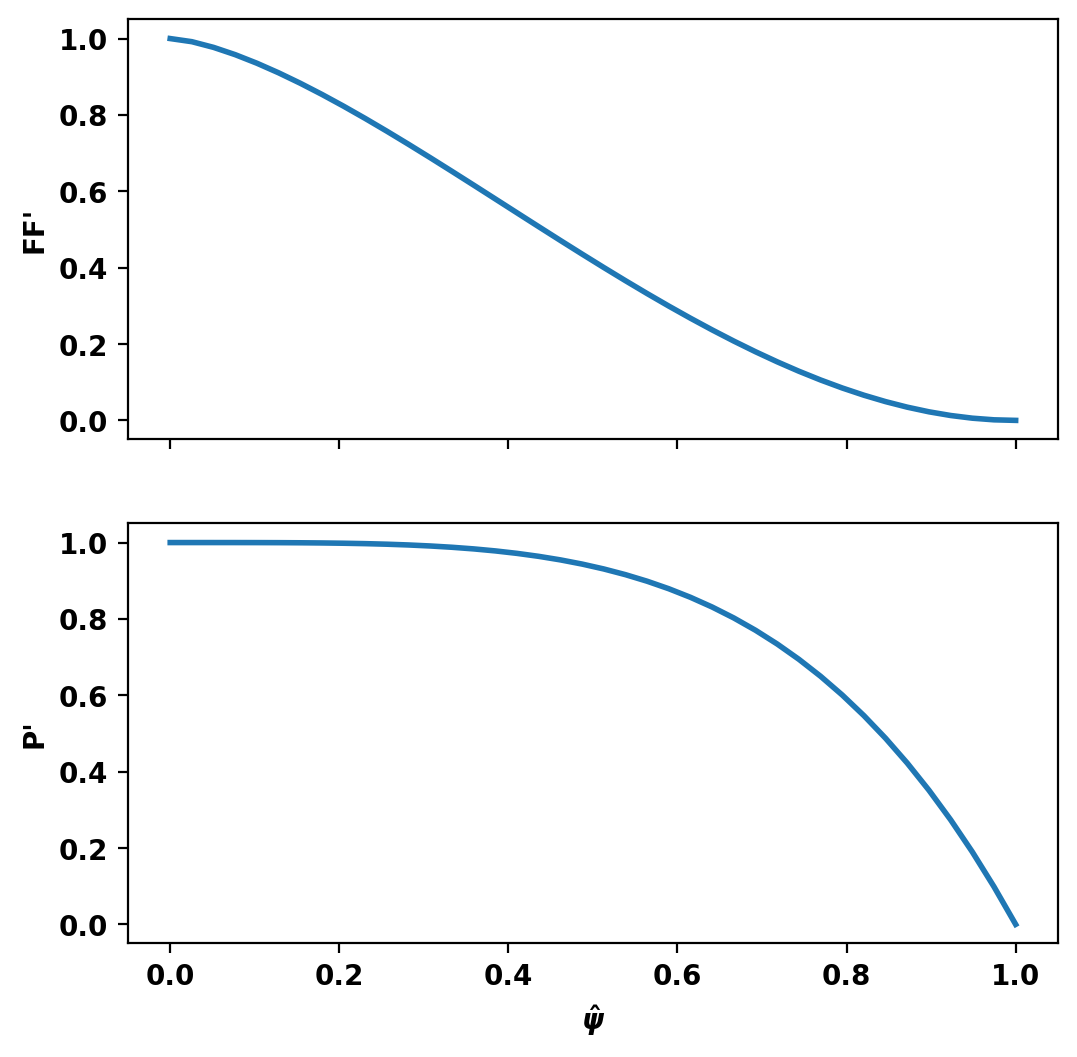

In [7]:
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 1.5
gamma = 2.0
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 4.0
gamma = 1.0
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Define global quantities and targets
For the Grad-Shafranov solve we define targets for the plasma current and the ratio the F*F' and P' contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$. In the scan below we will vary `Ip_ratio` to match different target $\beta$ values.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [8]:
Ip_target = 200.E3
mygs.set_targets(Ip=Ip_target,Ip_ratio=1.0)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets()" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the outboard side of the LCFS for the target equilibrium. Additionally, we define a two X-points and set them as saddle constraints. We also add the lower X-point to the list of isoflux points as we would like that to also lie on the LCFS as the active X-point.

In [9]:
isoflux_pts = create_isoflux(80,0.32,0.0,0.17,1.7,0.4)
# Trim isoflux constraints to outboard side only
isoflux_pts = isoflux_pts[isoflux_pts[:,0]>0.3,:]
# Add a single inboard point back in
isoflux_pts = np.vstack((isoflux_pts,np.array([[0.15,0.0],])))
# Define X-points
x_points = np.array([
    [0.22,-0.33],
    [0.20,0.34]
])
mygs.set_saddles(x_points)
mygs.set_isoflux(np.vstack((isoflux_pts,x_points[0,:])))

## Compute initial equilibrium
We can now compute a free-boundary equilibrium using these constraints and a starting $\beta_{approx}$ of 20%. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified `Ip_target`, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [10]:
beta_approx = 0.2
mygs.set_targets(Ip=Ip_target,Ip_ratio=(1.0/beta_approx - 1.0))
mygs.set_saddles(x_points)
mygs.set_isoflux(np.vstack((isoflux_pts,x_points)))
mygs.init_psi(0.32,0.0,0.13,1.7,0.4)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  2.3289E+00  1.4875E+00  6.3389E-03  3.4319E-01  7.2238E-04  1.8579E-22
     2  2.5451E+00  1.5358E+00  1.4525E-03  3.4133E-01  7.0454E-04 -5.3598E-22
     3  2.6170E+00  1.5572E+00  4.1098E-04  3.4050E-01  6.8582E-04 -5.6223E-22
     4  2.6494E+00  1.5676E+00  1.4804E-04  3.4011E-01  6.6961E-04 -2.0340E-21
     5  2.6649E+00  1.5728E+00  6.2511E-05  3.3992E-01  6.5617E-04 -2.9621E-23
     6  2.6725E+00  1.5753E+00  2.8547E-05  3.3983E-01  6.4538E-04  2.2009E-21
     7  2.6763E+00  1.5765E+00  1.3569E-05  3.3979E-01  6.3692E-04 -4.5748E-23
     8  2.6782E+00  1.5771E+00  6.6530E-06  3.3977E-01  6.3040E-04  2.6741E-22
     9  2.6792E+00  1.5775E+00  3.4151E-06  3.3976E-01  6.2543E-04  1.1756E-21
    10  2.6797E+00  1.5776E+00  1.8990E-06  3.3976E-01  6.2169E-04  1.2053E-21
    11  2.6800E+00  1.5777E+00  1.1754E-06  3.3976E-01  6.1890E-04  1.4399E-22
    12  2.6802E+00  1.5777E+00  7.9973E-07  3.3976E-01  6.1682E-04  1.0993E-21
 Timing:  0.1881630001

### Plot initial equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

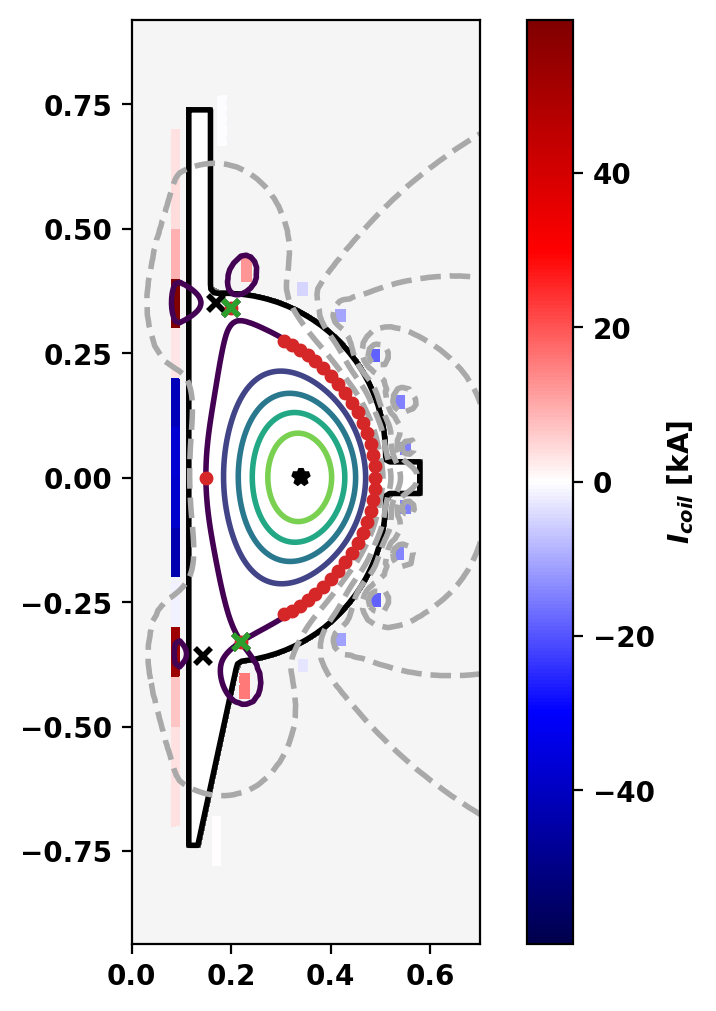

In [11]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=6,plasma_nlevels=6)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')

## Run stability scan

### Update settings
To reduce output we update settings to disable "performance monitoring" (eg. solver progress).

In [12]:
mygs.settings.pm=False
mygs.update_settings()

### Compute linear stability as a function of $\beta_p$
Now we perform a scan of $\beta_p$, computing the linear stability properties of the equilibrium at each point. We do this by looping over desired values of $\beta_p$ and performing the following steps at each point:

 1. Compute the desired equilibrium by
   1. Set the shape constraints (needed as we remove them in step 3)
   2. Re-initialize $\psi$ (needed as we evolve far from the initial equilibrium in step 3)
   3. Solve for the equilibrium, with a few iterations to converge the desired $\beta_p$
 2. Compute linear stability using \ref OpenFUSIONToolkit.TokaMaker.eig_td() "eig_td()"
   1. Save most unstable mode and growth rate
 3. Compute nonlinear evolution of a perturbed equilibrium
   1. Set the initial condition by adding a small contribution from the most unstable linear mode
   2. Remove saddle and isoflux constraints
   3. Setup the time-dependent solver
   4. Loop over 30 timesteps with a timestep determined by the linear growth rate, saving the equilibrium and vertical position at each time

In [13]:
growth = []
beta_p = []
modes = []
zhist = []
beta_scale = 1.0
for beta_target in np.linspace(0.01,0.8,10):
    print('Computing Beta_approx [%] {0:.2f}'.format(beta_target*100.0))
    # Compute new equilibrium
    mygs.set_saddles(x_points)
    mygs.set_isoflux(np.vstack((isoflux_pts,x_points)))
    mygs.init_psi(0.32,0.0,0.13,1.7,0.4)
    beta_approx = beta_target*beta_scale
    for i in range(4):
        mygs.set_targets(Ip=Ip_target,Ip_ratio=(1.0/beta_approx - 1.0))
        mygs.solve()
        beta_approx *= beta_target/mygs.get_stats()['beta_pol']*100.0
    beta_scale = beta_approx/beta_target
    beta_p.append(mygs.get_stats()['beta_pol'])
    print('  Actual Beta_p = {0:.2f}'.format(beta_p[-1]))
    psi0 = mygs.get_psi(False)
    # Compute linear stability
    eig_vals, eig_vecs = mygs.eig_td(-1.E5,10,False)
    eig_sign = eig_vecs[0,mygs.r[:,1]>0.0][abs(eig_vecs[0,mygs.r[:,1]>0.0]).argmax()]
    modes.append(eig_vecs[0,:]*eig_sign)
    growth.append(eig_vals[0,0])
    # Compute nonlinear evolution
    psi_ic = psi0-0.01*eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_sign
    mygs.set_psi(psi_ic)
    mygs.set_saddles(None)
    mygs.set_isoflux(None)
    dt = 0.2/abs(eig_vals[0,0])
    mygs.setup_td(dt,1.E-13,1.E-11)
    sim_time = 0.0
    results = []
    z0 = [[sim_time,mygs.o_point[1]],]
    for i in range(30):
        sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
        assert nretry >= 0
        z0.append([sim_time,mygs.o_point[1]])
        results.append(mygs.get_psi())
    zhist.append(z0)

Computing Beta_approx [%] 1.00
  Actual Beta_p = 1.00
Computing Beta_approx [%] 9.78
  Actual Beta_p = 9.78
Computing Beta_approx [%] 18.56
  Actual Beta_p = 18.55
Computing Beta_approx [%] 27.33
  Actual Beta_p = 27.33
Computing Beta_approx [%] 36.11
  Actual Beta_p = 36.11
Computing Beta_approx [%] 44.89
  Actual Beta_p = 44.79
Computing Beta_approx [%] 53.67
  Actual Beta_p = 53.63
Computing Beta_approx [%] 62.44
  Actual Beta_p = 62.45
Computing Beta_approx [%] 71.22
  Actual Beta_p = 71.22
Computing Beta_approx [%] 80.00
  Actual Beta_p = 80.01


### Plot growth rate trend
Once complete, we can plot the trend in the growth rate, which shows a decreasing growth rate for the vertical instability with increasing $\beta_p$.

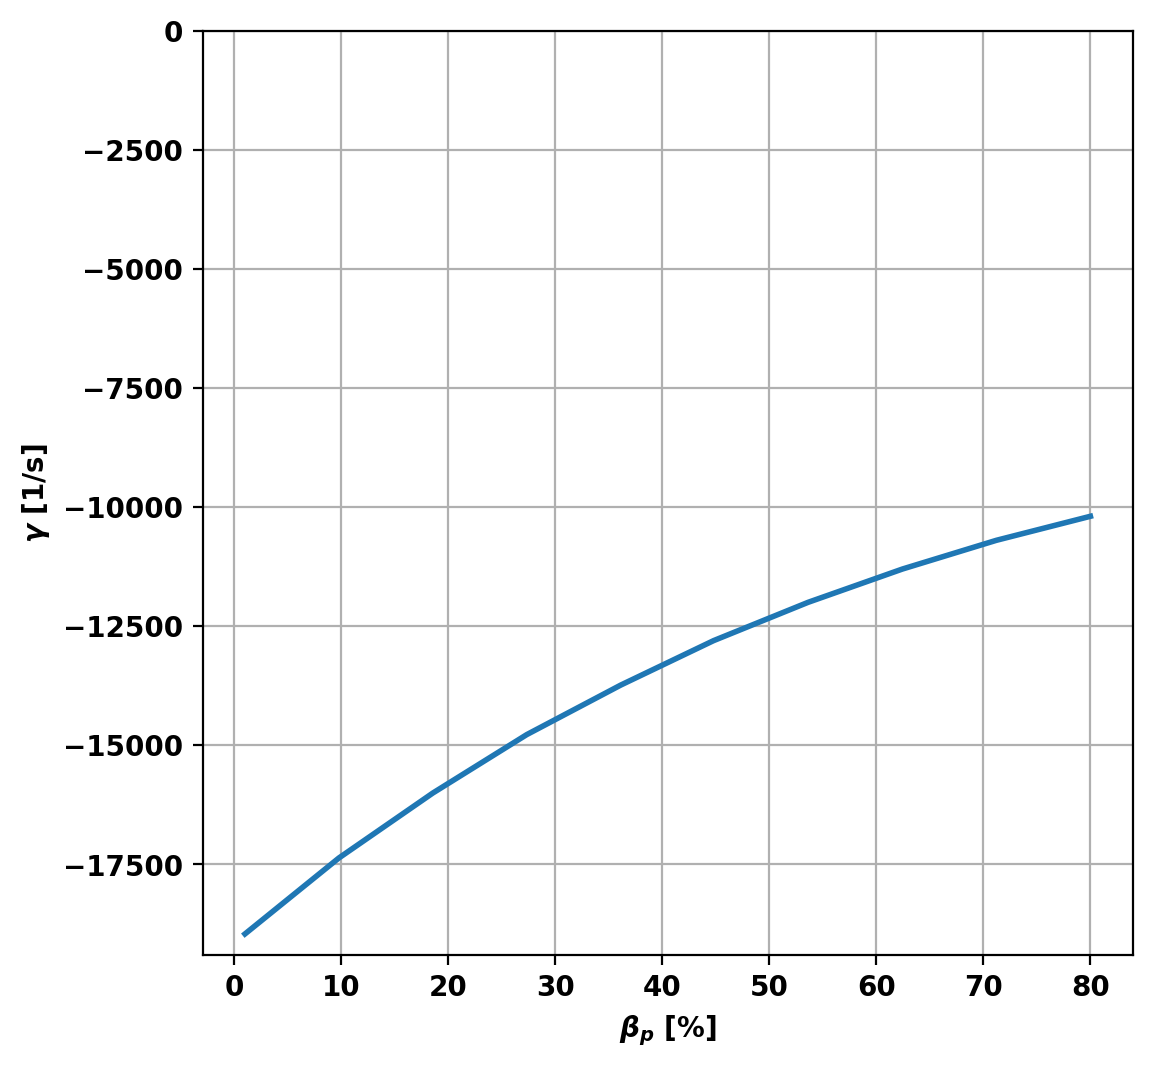

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(beta_p,growth)
ax.set_ylim(top=0.0)
ax.grid(True)
ax.set_ylabel(r'$\gamma$ [1/s]')
_ = ax.set_xlabel(r'$\beta_p$ [%]')

### Plot linear eigenmodes
To better understand why this trend occurs, we can plot the linearly unstable mode structure as a function of $\beta_p$. From this we can see that as $\beta_p$ increases the mode structure shifts outboard and more of the perturbed flux (relative to the peak value) interacts with the wall. As the resistivity of the wall is what sets the timescale in a time-dependent Grad-Shafranov model, this explains the decrease in growth rate as as higher $\beta_p$ more flux must move through the wall (via resisitive diffusion) for the same growth in amplitude.

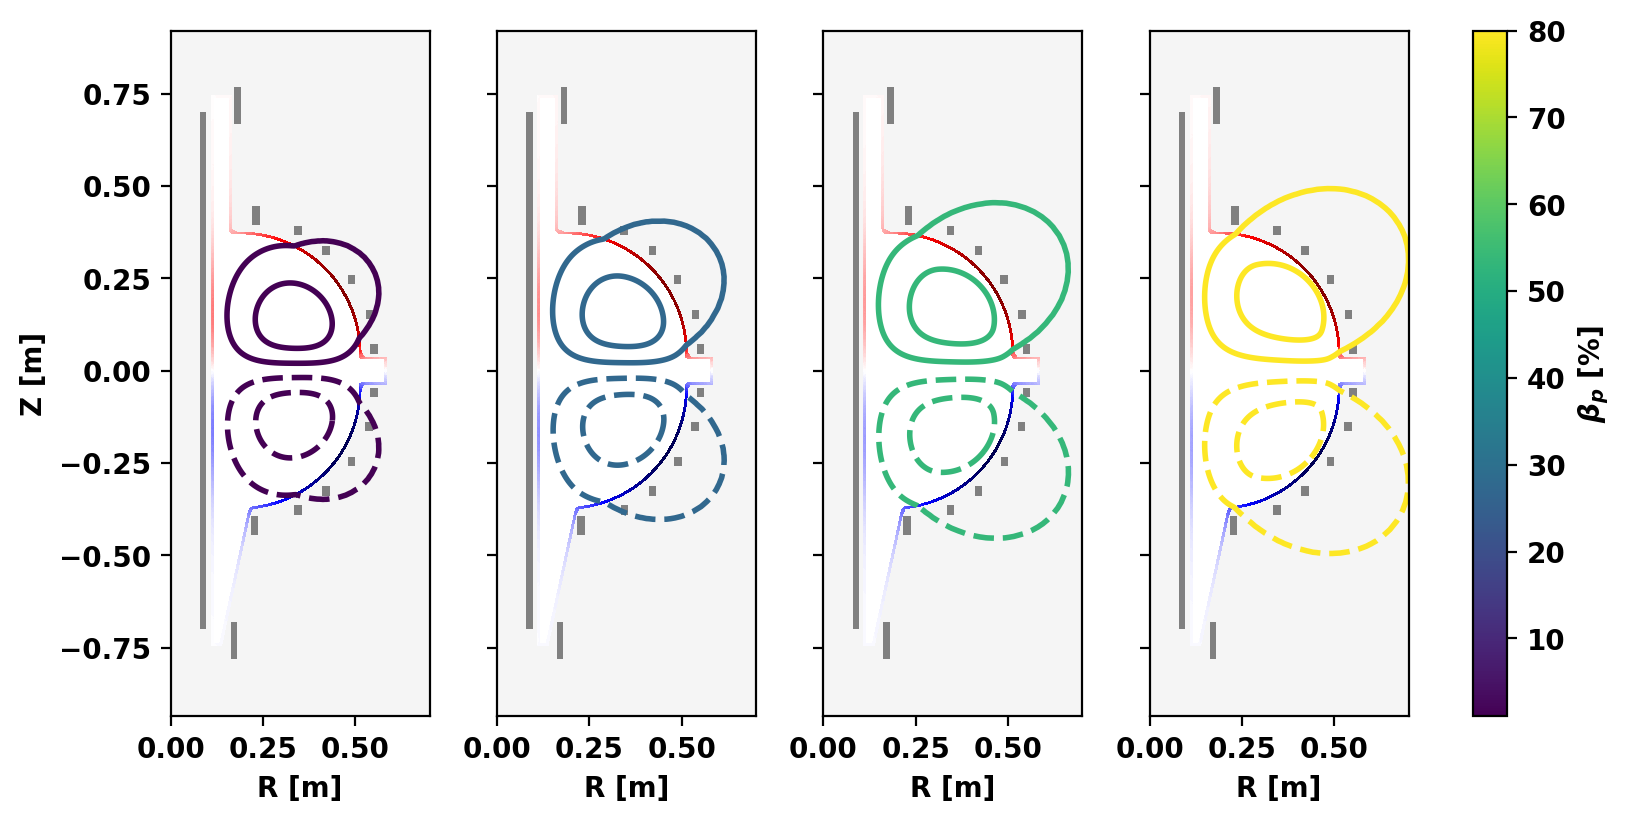

In [15]:
norm = mpl.colors.Normalize(vmin=beta_p[0], vmax=beta_p[-1])
scalarMap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
#
fig, ax = plt.subplots(1,4,sharey=True,constrained_layout=True,figsize=(8,4))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
for j, i in enumerate((0,3,6,9)):
    colorVal = scalarMap.to_rgba(beta_p[i])
    mygs.plot_psi(fig,ax[j],psi=modes[i],plasma_nlevels=6,normalized=False,plasma_color=[colorVal],opoint_color=None,xpoint_color=None,vacuum_nlevels=0)
    mygs.plot_eddy(fig,ax[j],dpsi_dt=modes[i]*abs(growth[i]),colormap='seismic',symmap=True,clabel=None)
for ax_tmp in ax:
    ax_tmp.set_xlabel(r'R [m]')
ax[0].set_ylabel(r'Z [m]')
_ = fig.colorbar(scalarMap,ax=ax[:],label=r'$\beta_p$ [%]')

### Plot nonlinear plasma evolution
We can also plot the evolution of the vertical position of the magnetic axis from the nonlinear evolution of each of the points in the $\beta_p$ scan. This shows the same behavior as the linear study (as expected of course), where the growth rate (velocity of the vertical position) decreases with increasing $\beta_p$. Additionally, clear linear (straight line on a log plot) and nonlinear phases are visible for each case.

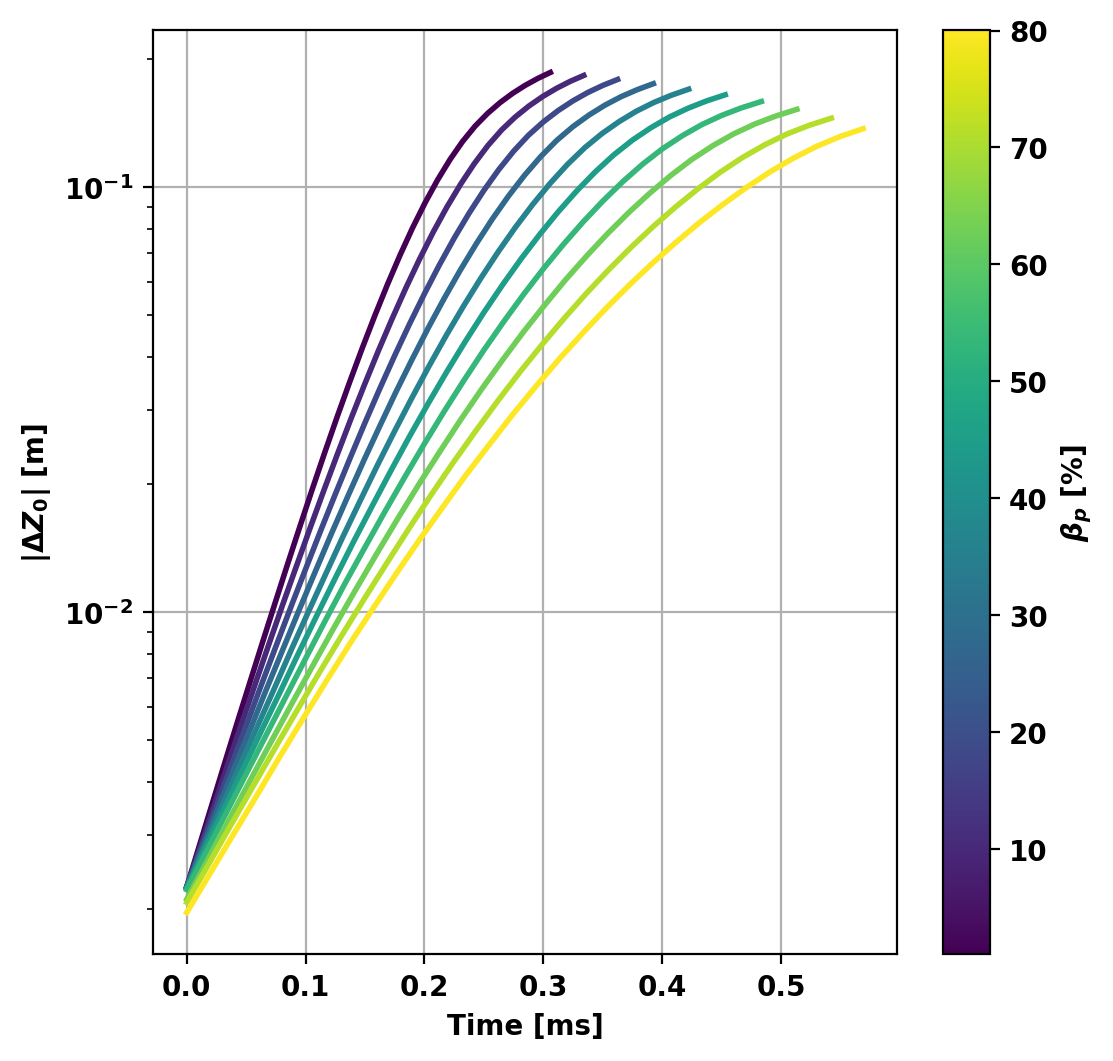

In [16]:
fig, ax = plt.subplots(1,1)
for i, z0 in enumerate(zhist):
    z_hist = np.asarray(z0); z_hist = z_hist[1:,:] - [z_hist[1,0], z_hist[0,1]]
    colorVal = scalarMap.to_rgba(beta_p[i])
    ax.semilogy(z_hist[:,0]*1.E3,abs(z_hist[:,1]),color=colorVal)
ax.grid(True)
ax.set_ylabel(r'$|\Delta Z_0|$ [m]')
ax.set_xlabel(r'Time [ms]')
_ = fig.colorbar(scalarMap,ax=ax,label=r'$\beta_p$ [%]')